In [65]:
import datetime
import random
from datetime import timedelta

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.neighbors import KNeighborsClassifier

from core.composer.gp_composer.gp_composer import \
    GPComposer, GPComposerRequirements
from core.composer.visualisation import ComposerVisualiser
from core.repository.model_types_repository import ModelTypesRepository
from core.repository.quality_metrics_repository import \
    ClassificationMetricsEnum, MetricsRepository
from core.repository.tasks import Task, TaskTypesEnum
from core.utils import probs_to_labels
from examples.utils import create_multi_clf_examples_from_excel


import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from benchmark.benchmark_utils import get_scoring_case_data_paths
from core.composer.chain import Chain
from core.composer.node import PrimaryNode, SecondaryNode
from core.models.data import InputData


random.seed(1)
np.random.seed(1)


def get_model_mod(train_file_path: str, cur_lead_time: datetime.timedelta = timedelta(minutes=6)):
    task = Task(task_type=TaskTypesEnum.classification)
    dataset_to_compose = InputData.from_csv(train_file_path, task=task)

    # the search of the models provided by the framework
    # that can be used as nodes in a chain for the selected task
    models_repo = ModelTypesRepository()
    available_model_types, _ = models_repo.suitable_model(task_type=task.task_type)

    metric_function = MetricsRepository(). \
        metric_by_id(ClassificationMetricsEnum.ROCAUC_penalty)
    

    
    composer_requirements = GPComposerRequirements(
        primary=['logit', 'lda'], secondary=['rf'],
        max_lead_time=cur_lead_time, max_arity=3,
        max_depth=4, pop_size=20, num_of_generations=100, 
        crossover_prob = 0.8, mutation_prob = 0.8, 
        add_single_model_chains = True)

    # Create the genetic programming-based composer, that allow to find
    # the optimal structure of the composite model
    composer = GPComposer()

    # run the search of best suitable model
    chain_evo_composed = composer.compose_chain(data=dataset_to_compose,
                                                initial_chain=None,
                                                composer_requirements=composer_requirements,
                                                metrics=metric_function, is_visualise=False)
    chain_evo_composed.fit(input_data=dataset_to_compose)

    return chain_evo_composed


def get_model_all(train_file_path: str, cur_lead_time: datetime.timedelta = timedelta(minutes=6)):
    task = Task(task_type=TaskTypesEnum.classification)
    dataset_to_compose = InputData.from_csv(train_file_path, task=task)

    # the search of the models provided by the framework
    # that can be used as nodes in a chain for the selected task
    models_repo = ModelTypesRepository()
    available_model_types, _ = models_repo.suitable_model(task_type=task.task_type)

    metric_function = MetricsRepository(). \
        metric_by_id(ClassificationMetricsEnum.ROCAUC_penalty)
    

    
    composer_requirements = GPComposerRequirements(
        primary=available_model_types, secondary=available_model_types,
        max_lead_time=cur_lead_time, max_arity=3,
        max_depth=4, pop_size=20, num_of_generations=100, 
        crossover_prob = 0.8, mutation_prob = 0.8, 
        add_single_model_chains = True)

    # Create the genetic programming-based composer, that allow to find
    # the optimal structure of the composite model
    composer = GPComposer()

    # run the search of best suitable model
    chain_evo_composed = composer.compose_chain(data=dataset_to_compose,
                                                initial_chain=None,
                                                composer_requirements=composer_requirements,
                                                metrics=metric_function, is_visualise=False)
    chain_evo_composed.fit(input_data=dataset_to_compose)

    return chain_evo_composed


def apply_model_to_data(model: Chain, data_path: str):
    df, file_path = create_multi_clf_examples_from_excel(data_path, return_df=True)
    dataset_to_apply = InputData.from_csv(file_path, with_target=True)
    evo_predicted = model.predict(dataset_to_apply)
    df['forecast'] = probs_to_labels(evo_predicted.predict)
    return df


def apply_model_to_data_and_predict(model: Chain, data_path: str):
    df, file_path = create_multi_clf_examples_from_excel(data_path, return_df=True)
    
    dataset_to_validate = InputData.from_csv(data_path)
    predicted_labels = model.predict(dataset_to_validate).predict
    
    
    test_data = InputData.from_csv(file_path, with_target=True)
    roc_auc_valid = round(roc_auc(y_true=test_data.target,
                                  y_score=predicted_labels,
                                  multi_class='ovo',
                                  average='macro'), 4)
    
    roc_auc_st = round(roc_auc(y_true=test_data.target, y_score=predicted_labels.round()), 4)
    
    p = round(precision_score(y_true=test_data.target,y_pred=predicted_labels.round()), 4)
    r = round(recall_score(y_true=test_data.target, y_pred=predicted_labels.round()), 4)
    a = round(accuracy_score(y_true=test_data.target, y_pred=predicted_labels.round()), 4)
    f = round(f1_score(y_true=test_data.target, y_pred=predicted_labels.round()), 4)
    
    return roc_auc_valid, roc_auc_st, p, r, a, f


def validate_model_quality(model: Chain, data_path: str):
    dataset_to_validate = InputData.from_csv(data_path)
    predicted_labels = model.predict(dataset_to_validate).predict

    roc_auc_valid = round(roc_auc(y_true=test_data.target,
                                  y_score=predicted_labels,
                                  multi_class='ovo',
                                  average='macro'), 4)
    
    roc_auc_st = round(roc_auc(y_true=test_data.target,y_score=predicted_labels), 4)
                              
    p = round(precision_score(y_true=test_data.target,y_pred=predicted_labels.round()), 4)
    r = round(recall_score(y_true=test_data.target, y_pred=predicted_labels.round()), 4)
    a = round(accuracy_score(y_true=test_data.target, y_pred=predicted_labels.round()), 4)
    f = round(f1_score(y_true=test_data.target, y_pred=predicted_labels.round()), 4)
    
    return roc_auc_valid, roc_auc_st, p, r, a, f


import time

In [4]:
def get_simple_chain():
    first = PrimaryNode(model_type='logit')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [5]:
train_file_path = r'./examples/data/creditcard_scaling_underSample/train.csv'
test_file_path = r'./examples/data/creditcard_scaling_underSample/test.csv'

In [6]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [7]:
chain = get_simple_chain()

In [8]:
chain.fit(train_data, use_cache=False);

OutputData(idx=array([ 1.36938448e+00, -2.79466220e-01, -9.78131768e-02, -2.53895060e-01,
       -1.09690491e-01,  2.51519598e-01, -1.20170474e-01, -2.96793125e-01,
        2.49798086e+01, -8.43987983e-02, -2.37546287e-01, -2.93439530e-01,
        1.19052610e-01, -2.79745686e-01,  2.50820932e-01, -2.93439530e-01,
        1.06211137e+00, -1.48396563e-01, -1.39733110e-03, -2.86173409e-01,
       -2.45231608e-01,  1.63236219e+00,  1.58066094e+00,  4.19199329e-02,
        4.28840914e-01, -2.94976595e-01,  5.65080696e+00, -3.07412841e-01,
        1.11087822e+00, -2.93439530e-01,  1.08977852e+00, -2.96653392e-01,
        3.03081115e+00, -2.93439530e-01,  3.61210089e-01, -2.52916929e-01,
       -2.54453993e-01,  6.41374974e-01,  4.72297911e+00,  2.33046880e+00,
       -2.51519598e-01,  2.43135611e-01,  1.50464613e+00, -2.93579264e-01,
        1.08977852e+00,  3.15601202e+00,  3.55760497e-01, -2.93439530e-01,
       -2.38244952e-01,  1.11786488e-01,  3.82868721e+00, -2.96373926e-01,
       -9.

In [9]:
before_tuning_predicted = chain.predict(test_data)

In [10]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)

p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
f = f1_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())

In [11]:
print(f'ROC_AUC = {bfr_tun_roc_auc} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nf1_score = {f}')

ROC_AUC = 0.9819226750261233 
PRECISION = 0.9764705882352941 
RECALL = 0.9540229885057471 
ACCURACY = 0.9695431472081218 
f1_score = 0.9651162790697674


# Apply model to full data

In [12]:
test_data = InputData.from_csv(r'./creditcard_scaling.csv')
before_tuning_predicted = chain.predict(test_data)

In [15]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target, y_score=before_tuning_predicted.predict)

p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
f = f1_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())

In [17]:
print(f'ROC_AUC = {bfr_tun_roc_auc} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nf1_score = {f}')

ROC_AUC = 0.9837294501446853 
PRECISION = 0.035890431747477046 
RECALL = 0.9613821138211383 
ACCURACY = 0.9553206206308131 
f1_score = 0.06919757150171896


In [1]:
print(f'ROC_AUC = {0.9856} \nPRECISION = {0.0376} \nRECALL = {0.9796} \nACCURACY = {0.9567}')

ROC_AUC = 0.9856 
PRECISION = 0.0376 
RECALL = 0.9796 
ACCURACY = 0.9567


In [61]:
file_path_first = r'./creditcard_scaling_underSample.csv'
# file_path_first = r'./creditcard_under.csv'
# file_path_first = r'./creditcard.csv'

#examples/utils.py replace read_excel => read_csv
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)
test_data = InputData.from_csv(test_file_path)
#Error!!!!
fitted_model = get_model(train_file_path)

ComposerVisualiser.visualise(fitted_model, save_path = f'./model8.jpg')

r1, r2, p, r, a, f = validate_model_quality(fitted_model, test_file_path)
print(f'ROC AUC metric = {r1} \nROC_AUC_ALL = {r2} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nF1_SCORE = {f}')

#0.972 

ROC AUC metric = 0.9696 
ROC_AUC_ALL = 0.9696 
PRECISION = 0.9759 
RECALL = 0.931 
ACCURACY = 0.9594 
F1_SCORE = 0.9529


In [ ]:
file_path_first = r'./creditcard_scaling_underSample.csv'
# file_path_first = r'./creditcard_under.csv'
# file_path_first = r'./creditcard.csv'

#examples/utils.py replace read_excel => read_csv
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)
test_data = InputData.from_csv(test_file_path)
#Error!!!!
fitted_model = get_model(train_file_path)

ComposerVisualiser.visualise(fitted_model, save_path = f'./model7.jpg')

r1, r2, p, r, a = validate_model_quality(fitted_model, test_file_path)
print(f'ROC AUC metric = {r1} \nROC_AUC_ALL = {r2} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a}') 

# Full dataset

## Composit

In [22]:
def get_simple_chain():
    first = PrimaryNode(model_type='logit')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [23]:
train_file_path = r'./examples/data/creditcard_scaling/train.csv'
test_file_path = r'./examples/data/creditcard_scaling/test.csv'

In [24]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [25]:
chain = get_simple_chain()

In [26]:
chain.fit(train_data, use_cache=False);

In [27]:
before_tuning_predicted = chain.predict(test_data)

In [28]:
bfr_tun_roc_auc = round(roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict), 4)

p = round(precision_score(test_data.target,before_tuning_predicted.predict.round()), 4)
r = round(recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)
a = round(accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()),4 )
f = round(f1_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)

In [29]:
print(f'ROC_AUC = {bfr_tun_roc_auc} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nf1_score = {f}')

ROC_AUC = 0.9027 
PRECISION = 0.7245 
RECALL = 0.7245 
ACCURACY = 0.9991 
f1_score = 0.7245


## Single

In [30]:
def get_simple_chain():
    first = PrimaryNode(model_type='mlp')

    chain = Chain(first)

    return chain

In [31]:
train_file_path = r'./examples/data/creditcard_scaling/train.csv'
test_file_path = r'./examples/data/creditcard_scaling/test.csv'

In [32]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [33]:
chain = get_simple_chain()

In [34]:
chain.fit(train_data, use_cache=False);

In [35]:
before_tuning_predicted = chain.predict(test_data)

In [36]:
bfr_tun_roc_auc = round(roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict), 4)

p = round(precision_score(test_data.target,before_tuning_predicted.predict.round()), 4)
r = round(recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)
a = round(accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()),4 )
f = round(f1_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)

In [37]:
print(f'ROC_AUC = {bfr_tun_roc_auc} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nf1_score = {f}')

ROC_AUC = 0.9609 
PRECISION = 0.9286 
RECALL = 0.7959 
ACCURACY = 0.9995 
f1_score = 0.8571


# BalancedUnder

## Composit

In [38]:
def get_simple_chain():
    first = PrimaryNode(model_type='rf')
    second = PrimaryNode(model_type='svc')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [39]:
train_file_path = r'./examples/data/creditcard_scaling_underSample/train.csv'
test_file_path = r'./examples/data/creditcard_scaling_underSample/test.csv'

In [40]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [41]:
chain = get_simple_chain()

In [42]:
chain.fit(train_data, use_cache=False);

In [43]:
before_tuning_predicted = chain.predict(test_data)

In [44]:
bfr_tun_roc_auc = round(roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict), 4)

p = round(precision_score(test_data.target,before_tuning_predicted.predict.round()), 4)
r = round(recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)
a = round(accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()),4 )
f = round(f1_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)

In [45]:
print(f'ROC_AUC = {bfr_tun_roc_auc} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nf1_score = {f}')

ROC_AUC = 0.9755 
PRECISION = 0.9651 
RECALL = 0.954 
ACCURACY = 0.9645 
f1_score = 0.9595


## Single

In [46]:
def get_simple_chain():
    first = PrimaryNode(model_type='mlp')

    chain = Chain(first)

    return chain

In [47]:
train_file_path = r'./examples/data/creditcard_scaling_underSample/train.csv'
test_file_path = r'./examples/data/creditcard_scaling_underSample/test.csv'

In [48]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [49]:
chain = get_simple_chain()

In [50]:
chain.fit(train_data, use_cache=False);

In [51]:
before_tuning_predicted = chain.predict(test_data)

In [52]:
bfr_tun_roc_auc = round(roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict), 4)

p = round(precision_score(test_data.target,before_tuning_predicted.predict.round()), 4)
r = round(recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)
a = round(accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()),4 )
f = round(f1_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round()), 4)

In [53]:
print(f'ROC_AUC = {bfr_tun_roc_auc} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nf1_score = {f}')

ROC_AUC = 0.9886 
PRECISION = 0.9762 
RECALL = 0.9425 
ACCURACY = 0.9645 
f1_score = 0.9591


Generation num: 0
spent time: 1.8 min
Best metric is -0.9956713333333334
Generation num: 1
spent time: 2.8 min
Best metric is -0.9956713333333334
Generation num: 2
spent time: 3.5 min
Best metric is -0.9956713333333334
Generation num: 3
spent time: 4.0 min
Best metric is -0.9956713333333334
Generation num: 4
spent time: 4.5 min
Best metric is -0.9956713333333334
Generation num: 5
spent time: 4.9 min
Best metric is -0.9956713333333334
Generation num: 6
spent time: 5.4 min
Best metric is -0.9956713333333334
Composition time: 5.417 min
Algorithm was terminated due to processing time limit
GP composition finished
ROC AUC metric = 0.9889 
ROC_AUC_ALL = 0.9889 
PRECISION = 0.9878 
RECALL = 0.931 
ACCURACY = 0.9645 
F1_SCORE = 0.9586


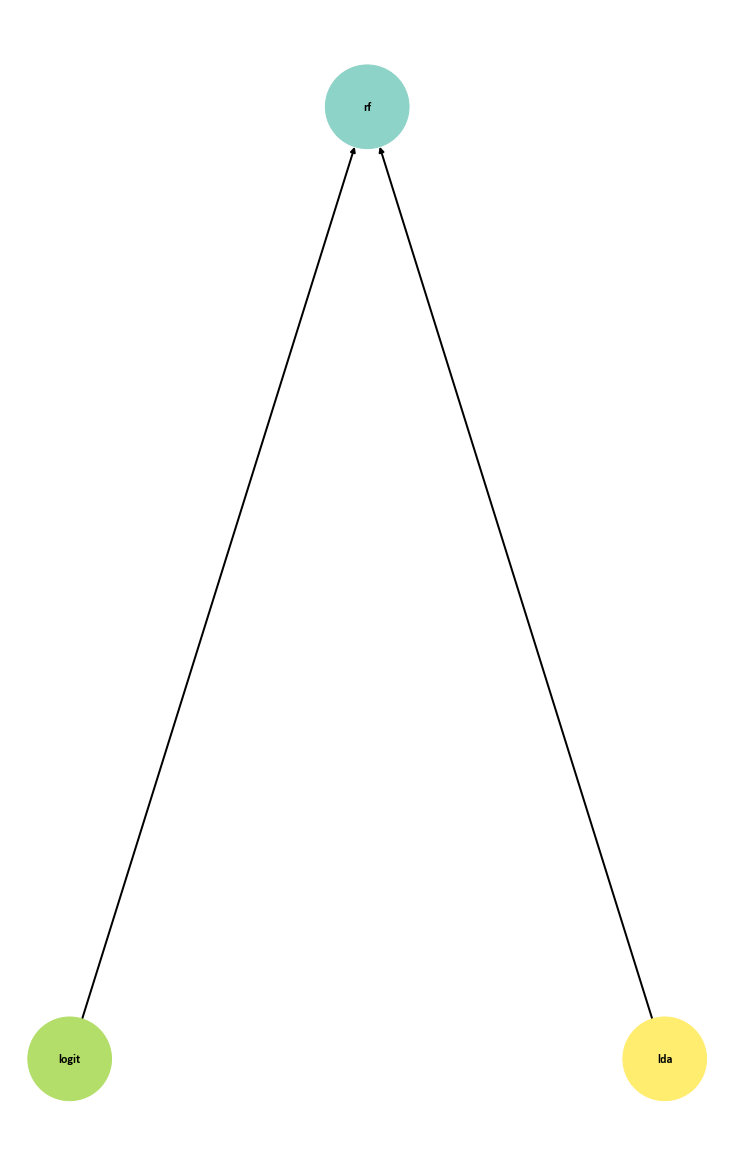

In [64]:
file_path_first = r'./creditcard_scaling_underSample.csv'
# file_path_first = r'./creditcard_under.csv'
# file_path_first = r'./creditcard.csv'

#examples/utils.py replace read_excel => read_csv
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)
test_data = InputData.from_csv(test_file_path)
#Error!!!!
fitted_model = get_model(train_file_path)

ComposerVisualiser.visualise(fitted_model, save_path = f'./model9.jpg')

r1, r2, p, r, a, f = validate_model_quality(fitted_model, test_file_path)
print(f'ROC AUC metric = {r1} \nROC_AUC_ALL = {r2} \nPRECISION = {p} \nRECALL = {r} \nACCURACY = {a} \nF1_SCORE = {f}')

#0.972 

In [ ]:
Профайлер на каких трех секундах тратиться